# BCC Text Dataset

Here we will build a classification model for the following dataset.
    
https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
bbc_df = pd.read_csv(r"https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv")

In [3]:
bbc_df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


# Class Imbalance Check

<AxesSubplot:>

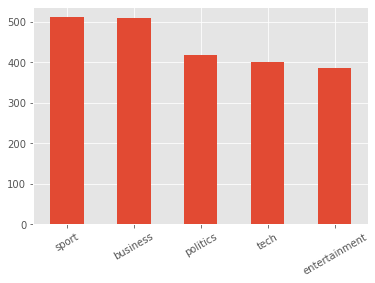

In [4]:
counts = bbc_df.category.value_counts()
counts.plot(kind='bar', rot=30)

In [5]:
bbc_df.shape

(2225, 2)

Let's use  the Google Developer Guide to figure out which kind of model to use (https://developers.google.com/machine-learning/guides/text-classification). We have 2225 samples, so let's 
calculate median number of words per sample. 

In [6]:
from nltk.tokenize import word_tokenize
word_counts = bbc_df.text.apply(lambda v: len(word_tokenize(v)))

In [7]:
word_counts.median()

357.0

In [8]:
bbc_df.shape[0] / word_counts.median()

6.23249299719888

This is a pretty low number, so according to the recommendation we should use an n-gram model.

In [9]:
bbc_df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


# Split Data for Train and Test

Next we split the data for train and test.`

In [21]:
categories = bbc_df.category.astype('category')
bbc_df.loc[:, 'category'] = categories.cat.codes

In [22]:
train_df = bbc_df.groupby('category', as_index=False).sample(frac=0.7)
train_df.shape

(1558, 2)

In [23]:
train_df.category.value_counts()

3    358
0    357
2    292
4    281
1    270
Name: category, dtype: int64

In [24]:
test_df = bbc_df.loc[bbc_df.index.difference(train_df.index), :]

In [25]:
test_df.category.value_counts()

3    153
0    153
2    125
4    120
1    116
Name: category, dtype: int64

# Build Scikit Learn Model

We will combine a CountVectorizer and a RandomForestClassifier in a pipeline to build a simple text classification model. We will use 1 and 2-grams and also use the binary mode (presence / absence of number of tokens). 

In [102]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [124]:
model = Pipeline([
    ('count', CountVectorizer(ngram_range=(1, 2), max_features=5000, binary=True)),
    ('rf', RandomForestClassifier(n_estimators=90, max_depth=4))
])

cv = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
scores = cross_val_score(model, train_df.text.values, train_df.category.values, cv=cv)

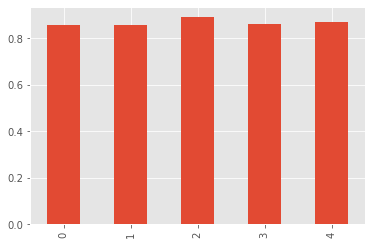

In [125]:
scores = pd.Series(scores) 
_ = scores.plot(kind='bar', rot=90)

In [126]:
scores.mean()

0.8684186660070903

This looks pretty good, so we will evaluate the model using the test set and produce a classification report.

In [127]:
model = Pipeline([
    ('count', CountVectorizer(ngram_range=(1, 2), max_features=5000, binary=True)),
    ('rf', RandomForestClassifier(n_estimators=90, max_depth=4))
])


model = model.fit(train_df.text.values, train_df.category.values)
predictions = model.predict(test_df.text.values)

In [128]:
from sklearn.metrics import classification_report

print(classification_report(predictions, test_df.category))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85       197
           1       0.66      0.99      0.79        78
           2       0.73      0.98      0.83        93
           3       0.99      0.77      0.87       196
           4       0.82      0.96      0.89       103

    accuracy                           0.85       667
   macro avg       0.84      0.89      0.85       667
weighted avg       0.88      0.85      0.85       667

